In [1]:
%load_ext autoreload
%autoreload 2

import re
import traceback

import numpy as np
from matplotlib import pyplot as plt

from numpy import seterr as np_seterr
from scipy.optimize import curve_fit

from hex_check import hex_check
from extinction_plots import plot_fft_peak, \
    plot_1d_histogram, plot_normalized_histogram
from extinction_functions import simulate_delta_train, get_delta_trains_from_hex, \
    get_three_fold_coincidence_points, report_results_with_error, symmetric_mod, center_pulses, \
    lorentzian, center_pulses, combine_periods

from socketudp.extinction_plots import plot_2d_histogram_time_vs_event_number
from socketudp.extinction_functions import get_delta_trains_per_event_from_hex


np_seterr(all='raise')

ADC length: 1
Used input file data_20250711_024604.dat
Peak height data saved to img/2025.07.11_07.02.48_data_20250711_024604.dat/peak_height_data_data_20250711_024604.dat.csv
No plotting mode specified. Skipping plotting.



{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
last_event = hex_check.event_buffer[-1]
print(f"# Events / Subevents: {last_event.internal_event_number} / {last_event.sub_event_number}")

# all times in this file are in nanoseconds unless otherwise specified
signal_period = 1 / 589.9801  # ns, the nominal period of the signal, 1694.97242 ns
sample_rate = 4  # ns, the sampling rate of the signal (4 ns per sample)

use = "real_data"  # "real_data" or "simulated_data"
# FOR SIMULATED DATA
length_ms = 30
length_ns: int = int(length_ms * 1e6)  # ns, total time for the delta train
# arrival_jitter derived based on requirement for ~99.99893% of protons within ±125 ns
arrival_jitter_ns = 27.14
particle_num_mean = 3
particle_num_width = 2
noise_num_mean = 0.1
noise_num_width = 0.15
phase_offset_deg = 0
gradual_phase_shift_speed_ns = 5  # ns, the speed of the gradual phase shift in the signal

# OTHER SETTINGS
desired_f_resolution = 0.1  # kHz, desired frequency resolution for the FFT
zero_padding_ratio = 5  # set to None to calc. zero padding based on desired_f_resolution
common_title_text = ""  # leave unfilled, is set at beginning of main()

# 4 ns sample rate
# total_time = 1695 * 501 ns = 849,195 ns = 0.849195 ms
# fs = 1 / (4e-9) = 250 MHz
# fn = fs / 2 = 125 MHz
print(f"Sampling rate (fs): {1 / sample_rate * 1e6} MHz ({sample_rate} ns)")
print(f"Nyquist frequency (fn): {1 / (2 * sample_rate) * 1e6} MHz ({2 * sample_rate} ns)")

if use == 'real_data':
    common_title_text = f"{hex_check.file_name}"
else:
    common_title_text = f"Simulated Delta Train (length: {length_ms} ms, "
    common_title_text += f"signal period: {signal_period} ns, sample rate: {sample_rate} ns)"

# Events / Subevents: 70 / 65
Sampling rate (fs): 250000.0 MHz (4 ns)
Nyquist frequency (fn): 125000.0 MHz (8 ns)


In [3]:
def get_delta_train(channel, fft_time_range_ns: tuple[float, float] = (None, None)):
    global common_title_text
    if use == "real_data":
        delta_train, fft_time_range_ns = get_delta_trains_from_hex(hex_check, channel, fft_time_range_ns)
        print(delta_train[0], delta_train[-1], )
        if "Time Range" not in common_title_text:
            common_title_text += (f"\nTime Range: {delta_train[0] * 1e-6:.2f} "
                                  f"to {delta_train[-1] * 1e-6:.2f} ms")
    elif use == "simulated_data":
        delta_train = simulate_delta_train(signal_period, phase_offset_deg, arrival_jitter_ns,
                                           particle_num_mean, particle_num_width, noise_num_mean,
                                           noise_num_width,
                                           length_ns, sample_rate)
        fft_time_range_ns = (delta_train[0], delta_train[-1])  # default to full range
    else:
        raise ValueError("Invalid use case. Use 'real_data' or 'simulated_data'.")

    return delta_train, fft_time_range_ns

1
[CH1] Event 1: 1715 events.
[CH1] After time mask, 1715 events remain in 0.00–0.00 ms
[CH1] Event 2: 1540 events.
[CH1] After time mask, 1540 events remain in 0.00–0.00 ms
[CH1] Event 3: 1715 events.
[CH1] After time mask, 1715 events remain in 0.00–0.00 ms
[CH1] Event 4: 1680 events.
[CH1] After time mask, 1680 events remain in 0.00–0.00 ms
[CH1] Event 5: 1680 events.
[CH1] After time mask, 1680 events remain in 0.00–0.00 ms
[CH1] Event 6: 1680 events.
[CH1] After time mask, 1680 events remain in 0.00–0.00 ms
[CH1] Event 7: 1680 events.
[CH1] After time mask, 1680 events remain in 0.00–0.00 ms
[CH1] Event 8: 1715 events.
[CH1] After time mask, 1715 events remain in 0.00–0.00 ms
[CH1] Event 10: 1715 events.
[CH1] After time mask, 1715 events remain in 0.00–0.00 ms
[CH1] Event 11: 1715 events.
[CH1] After time mask, 1715 events remain in 0.00–0.00 ms
[CH1] Event 12: 1855 events.
[CH1] After time mask, 1855 events remain in 0.00–0.00 ms
[CH1] Event 13: 1715 events.
[CH1] After time mas

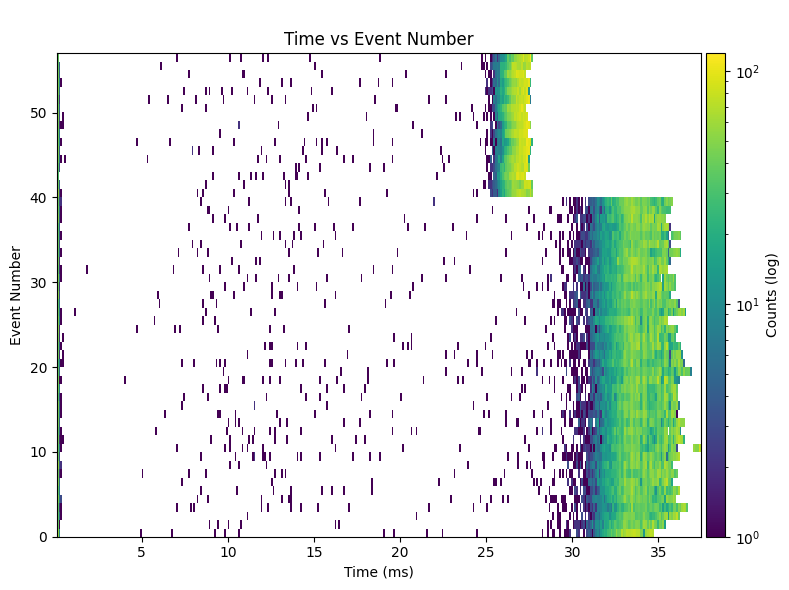

In [4]:
def get_delta_train_per_event(channel: int, fft_time_range_ns: tuple[float, float] = (None, None)):
    """
    Get delta train for a specific channel and event.
    :param channel: Channel number (1, 2, or 3).
    :param fft_time_range_ns: Time range for FFT in nanoseconds.
    :return: Delta train and time range for FFT.
    """
    r = get_delta_trains_per_event_from_hex(hex_check, channel, fft_time_range_ns, units='ms')
    return r

delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(1, (0, np.inf))

plot_2d_histogram_time_vs_event_number(
    delta_trains_per_event,
    bin_width = 0.1,
    units='ms',
)

In [5]:
def fft(channel: int, delta_train, fft_time_range_ns):
    global signal_period
    global length_ns
    global common_title_text
    global zero_padding_ratio

    if use == "real_data":
        if " - Channel" in common_title_text:
            common_title_text = re.sub(r' - Channel \d', f' - Channel {channel}', common_title_text)
        else:
            common_title_text += f" - Channel {channel}"

    # #######################################################
    # Parameter Setup
    # #######################################################

    length_ns = int(delta_train[-1] - delta_train[0])  # total time in ns
    print(f"[CH{channel}] Total time: {length_ns * 1e-6:.3f} ms")
    # to calc. minimum allowed sampling frequency, use Nyquist theorem:
    # know we want to measure 1 / 1695 ns = 590.5 kHz, so we need at least 2 * 590.5 kHz = 1.181 MHz
    # corresponds to a sampling time of 1 / 1.181 MHz = 846.5 ns
    # anything outside of that will be aliased
    theoretical_peak_width: float = 1 / length_ns * 1e6  # kHz, theoretical peak width in kHz
    print(f"[CH{channel}] Expected theoretical peak width: {theoretical_peak_width:.4f} kHz")

    # start creating bins
    n_bins = int(np.round((fft_time_range_ns[1] - fft_time_range_ns[0]) / sample_rate)) + 1
    t = np.arange(n_bins) * sample_rate + fft_time_range_ns[0]  # time bins in ns, starting at first absolute time

    bin_counts = np.zeros(len(t)).astype(int)  # initialize bin counts
    zero_start_delta_train = delta_train - (t[0] - t[0] % sample_rate)  # zero start time
    bin_indices = np.round(zero_start_delta_train / sample_rate).astype(int)  # bin indices for each delta
    # add counts to the corresponding bins
    bin_counts[bin_indices] += 1

    # calculate zero_padding ratio based on desired frequncy resolution
    if zero_padding_ratio is None:
        zero_padding_ratio = round(1e6 / length_ns / desired_f_resolution)  # zero padding ratio
    zero_padded_width = 1 / (length_ns * zero_padding_ratio) * 1e6
    print(f"[CH{channel}] Zero padding ratio: {zero_padding_ratio} (to achieve {zero_padded_width:.4f} kHz "
          f"interpolated resolution)")

    # #######################################################
    # FFT Calculation
    # #######################################################

    # optional, apply window if you wish
    # sometimes helps, sometimes doesn't
    # window = windows.hann(len(bin_counts))
    # bin_counts *= window  # Apply a Hann window to the signal

    # Take the FFT
    amp_exponent = 1  # exponent for amplitude, can be 1 for amplitude or 2 for power spectrum
    fft_result = 1 / len(t) * np.fft.fft(bin_counts, n=zero_padding_ratio * len(t))
    fft_abs = np.abs(fft_result) ** amp_exponent
    fft_freqs = np.fft.fftfreq(len(fft_result), d=sample_rate * 1e-6)  # convert to kHz
    unpadded_df = 1 / (sample_rate * 1e-6) / len(bin_counts)

    # keep positive frequencies only
    fft_abs = fft_abs[:len(fft_abs) // 2]
    fft_freqs = fft_freqs[:len(fft_freqs) // 2]
    # mask out DC component (less than 1 kHz)
    fft_mask = fft_freqs >= 1
    fft_abs = fft_abs[fft_mask]
    fft_freqs = fft_freqs[fft_mask]

    # mini range from just above 589 kHz to just below 591 kHz
    expected_peak = 590
    f_range = (expected_peak - 8 * theoretical_peak_width,
               expected_peak + 8 * theoretical_peak_width)
    fft_mask = (f_range[0] <= fft_freqs) & (fft_freqs <= f_range[1])
    mini_fft_abs = fft_abs[fft_mask]
    mini_fft_freqs = fft_freqs[fft_mask]
    max_idx = np.argsort(mini_fft_abs)[::-1][0]  # Get index of highest bin in mini_fft_abs
    fft_f = mini_fft_freqs[max_idx]  # the frequency FFT bin of the peak
    fft_amp = mini_fft_abs[max_idx]  # amp of that peak
    print(f"[CH{channel}] FFT Peak Frequency: {fft_f:.3f} kHz, Amplitude: {fft_amp:.3f} "
          f"(searched between {mini_fft_freqs[0]:.3f} kHz and {mini_fft_freqs[-1]:.3f} kHz)")

    # #######################################################
    # FFT Peak Fitting
    # #######################################################

    # pull out just the +/- 0.5 kHz around peak for the fit
    fft_fit_window_mask = (np.abs(mini_fft_freqs - fft_f) < theoretical_peak_width * 5)  # +/- 0.5 kHz
    freq_window = mini_fft_freqs[fft_fit_window_mask]
    amp_window = mini_fft_abs[fft_fit_window_mask]

    # do fit
    p0 = [fft_amp, fft_f, theoretical_peak_width, 0]
    popt, pcov = curve_fit(lorentzian, freq_window, amp_window, p0=p0, maxfev=10000)
    A_fit, detected_frequency, sigma_fit, offset_fit = popt

    # calculate period from detected fit frequency
    detected_period = 1 / detected_frequency * 1e6  # ns, looks like 1694.99 ns

    # uncertainty in detected frequency
    detected_frequency_error = np.sqrt(np.diag(pcov))[1]  # second element is frequency
    # propagate to period error
    period_fit_error = detected_frequency_error / (detected_frequency ** 2) * 1e6  # ns

    final_channel_error = report_results_with_error(fft_freqs, fft_abs, unpadded_df, mini_fft_abs, max_idx,
                                                    zero_padding_ratio, detected_frequency,
                                                    length_ns, detected_period, detected_frequency_error, channel)

    # #######################################################
    # Plot FFT Peak / Fitting Result
    # #######################################################

    plot_fft_peak(mini_fft_freqs, mini_fft_abs, freq_window, amp_window, popt, amp_exponent,
                  common_title_text, delta_train, detected_frequency, detected_period, fft_time_range_ns,
                  file_name = f"img/{hex_check.folder_name}/fft_peak.png",
                  title = (f"FFT Peak Fitting Result - Time Range: {delta_train[0] * 1e-6:.2f} to "
                            f"{delta_train[-1] * 1e-6:.2f} ms"),
                  figsize=(8, 3),
                  )

    return delta_train, detected_period, final_channel_error

[CH1] Using real data from channel 1 with 84875 events.
[CH1] First event time: 77848.00 ns, 
[CH1] After time mask, 84875 events remain in the time range 77836.00 to 37471564.00 ms
77836 37471564

[CH2] Using real data from channel 2 with 84876 events.
[CH2] First event time: 77844.00 ns, 
[CH2] After time mask, 84875 events remain in the time range 77800.00 to 36908852.00 ms
77800 36908852

[CH3] Using real data from channel 3 with 86279 events.
[CH3] First event time: 77780.00 ns, 
[CH3] After time mask, 86275 events remain in the time range 77748.00 to 33266372.00 ms
77748 33266372

[CH1] Total time: 37.394 ms
[CH1] Expected theoretical peak width: 0.0267 kHz
[CH1] Zero padding ratio: 5 (to achieve 0.0053 kHz interpolated resolution)
[CH1] FFT Peak Frequency: 589.990 kHz, Amplitude: 0.006 (searched between 589.790 kHz and 590.210 kHz)
[CH1] Signal power: 3.435e-05 W, Average noise bin: 3.548e-10 W, Noise density: 1.419e-11 W/Hz, SNR: 2420470.95 (T = 37.393728 ms, zero padding ratio

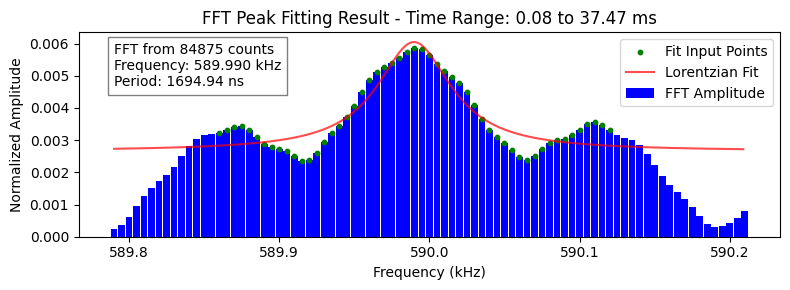


[CH2] Total time: 36.831 ms
[CH2] Expected theoretical peak width: 0.0272 kHz
[CH2] Zero padding ratio: 5 (to achieve 0.0054 kHz interpolated resolution)
[CH2] FFT Peak Frequency: 589.990 kHz, Amplitude: 0.006 (searched between 589.785 kHz and 590.215 kHz)
[CH2] Signal power: 3.053e-05 W, Average noise bin: 3.404e-10 W, Noise density: 1.362e-11 W/Hz, SNR: 2242469.40 (T = 36.831052 ms, zero padding ratio = 5)
[CH2] Fitted frequency: 589.989 ± 0.0001 ± 0.0021 kHz (SNR error, fit error)
[CH2] Fitted period: 1694.9457 ± 0.0003 ± 0.0059 ns (SNR error, fit error)


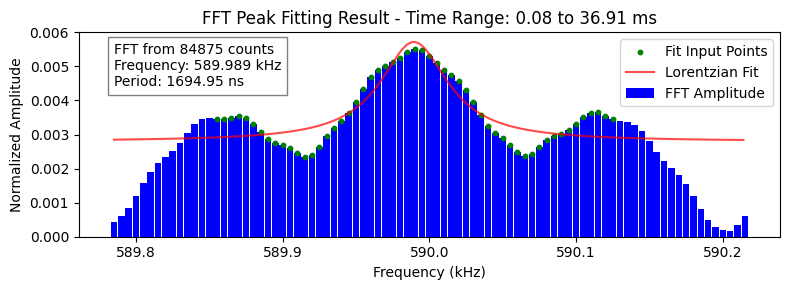


[CH3] Total time: 33.189 ms
[CH3] Expected theoretical peak width: 0.0301 kHz
[CH3] Zero padding ratio: 5 (to achieve 0.0060 kHz interpolated resolution)
[CH3] FFT Peak Frequency: 589.990 kHz, Amplitude: 0.005 (searched between 589.760 kHz and 590.240 kHz)
[CH3] Signal power: 2.400e-05 W, Average noise bin: 3.872e-10 W, Noise density: 1.549e-11 W/Hz, SNR: 1549586.26 (T = 33.188624 ms, zero padding ratio = 5)
[CH3] Fitted frequency: 589.990 ± 0.0002 ± 0.0023 kHz (SNR error, fit error)
[CH3] Fitted period: 1694.9438 ± 0.0005 ± 0.0065 ns (SNR error, fit error)


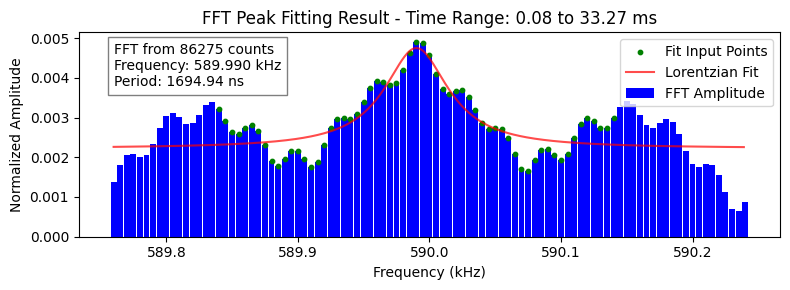


Averaged Period: 1694.944845 ns, Error: 0.000447 ns (std.dev error)
Input mean: 1694.944844750 ns
Weighted mean: 1694.944910298 ns
Weighted error (uncorrelated only): ±0.003299 ns
Chi²/dof: 0.0458 / 2 = 0.0229
Birge ratio: 0.151
Final result: 1694.944910298 ± 0.003299 ns


In [6]:
fft_range = (0e6, 40e6)
ch1, fft_range_1 = get_delta_train(1, fft_range)
print()
ch2, fft_range_2 = get_delta_train(2, fft_range)
print()
ch3, fft_range_3 = get_delta_train(3, fft_range)
print()

total_fft_range = (min(fft_range_1[0], fft_range_2[0], fft_range_3[0]),
                     max(fft_range_1[1], fft_range_2[1], fft_range_3[1]))

# Run three FFTs / calculate average period

chs = [ch1, ch2, ch3]
periods: list[float] = []
period_errors: list[float] = []
delta_trains = []

for i in range(3):
    r = fft(i+1, chs[i], (total_fft_range[0], total_fft_range[1]))
    delta_trains.append(r[0])
    periods.append(r[1])
    period_errors.append(r[2])
    print()

# ##########
# COMBINE PERIODS
# ##########
period = np.mean(periods)
period_error = np.std(periods) / np.sqrt(len(periods))
print(f"Averaged Period: {period:.6f} ns, Error: {period_error:.6f} ns (std.dev error)")

weighted_period, final_error = combine_periods(period, periods, period_errors)

[autoreload of extinction_plots failed: Traceback (most recent call last):
  File "C:\Users\ryry0\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "C:\Users\ryry0\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 524, in maybe_reload_module
    new_source_code = f.read()
  File "C:\Users\ryry0\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 23277: character maps to <undefined>
]


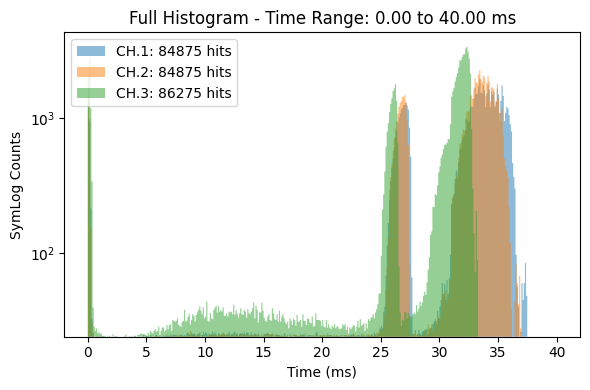

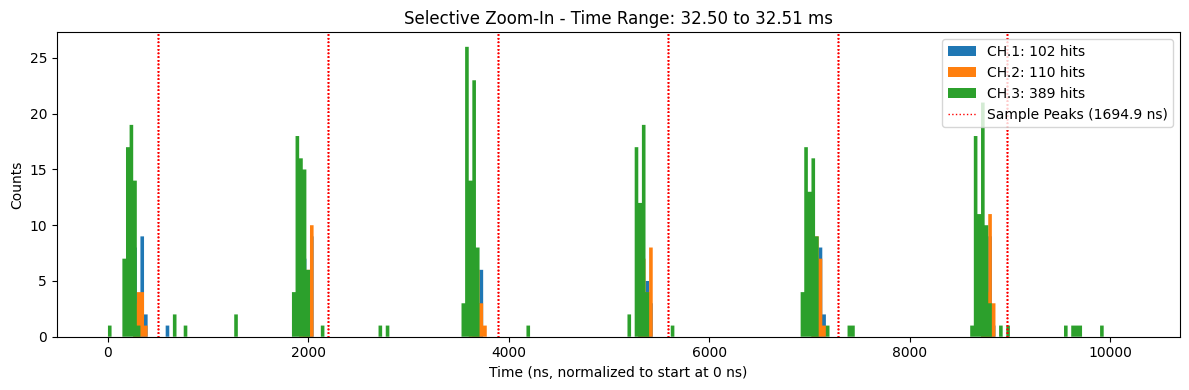

In [33]:
plot_1d_histogram([ch1, ch2, ch3], common_title_text=common_title_text, hist_range=total_fft_range,
                  title=f"Full Histogram - Time Range: {total_fft_range[0] * 1e-6:.2f} to {total_fft_range[1] * 1e-6:.2f} ms",
                  fig_size=(6, 4), file_name=f"img/{hex_check.folder_name}/full_histogram.svg", loc="upper left",
                  log=True, )

start = 32.5e6 - 32.5e6 % period - 500
end = start + period * 6

plot_1d_histogram([ch1, ch2, ch3], common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=period, hist_range=(start, end), loc="best", alpha=1, bin_size_ns=36,
                  fig_size = (12, 4), sample_offset=500,
                  file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_zoomed_1d_histogram.svg",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.2f} to {end * 1e-6:.2f} ms",
                  units='ns')


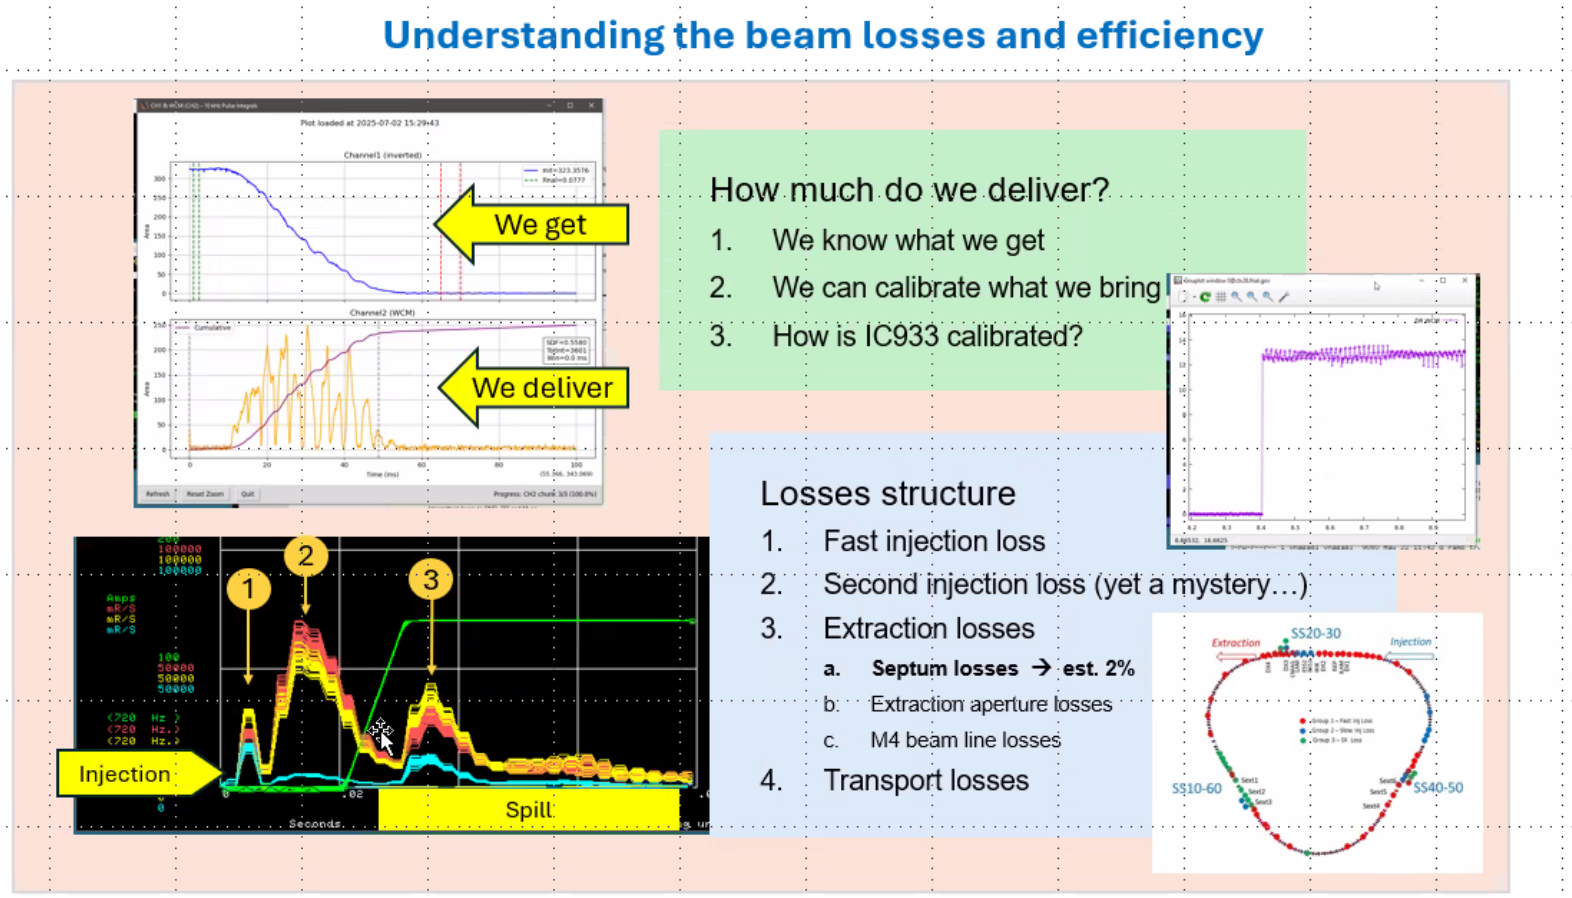

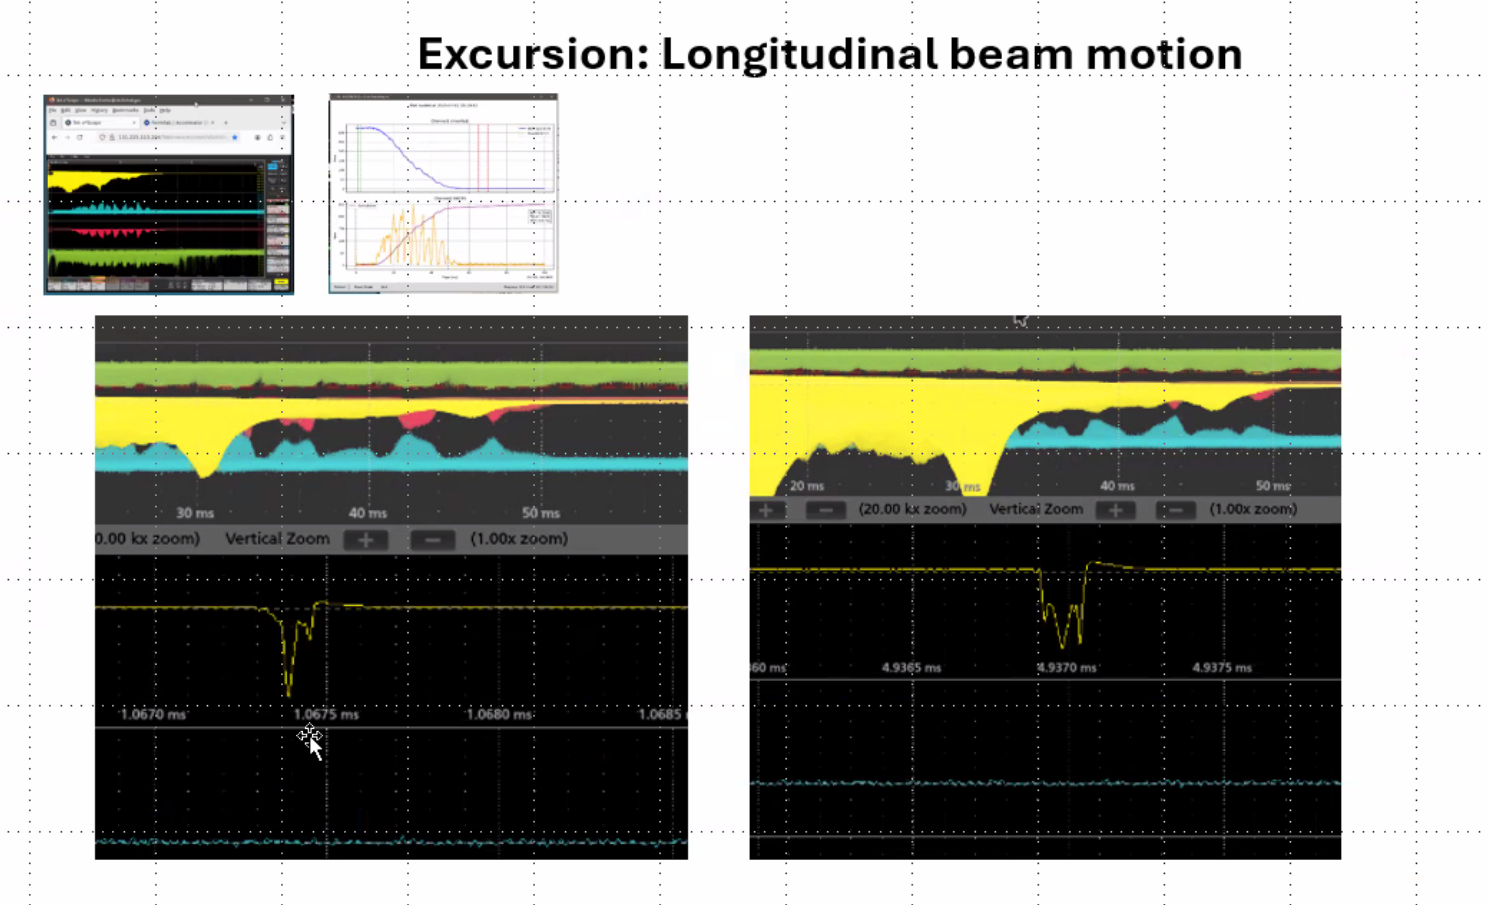

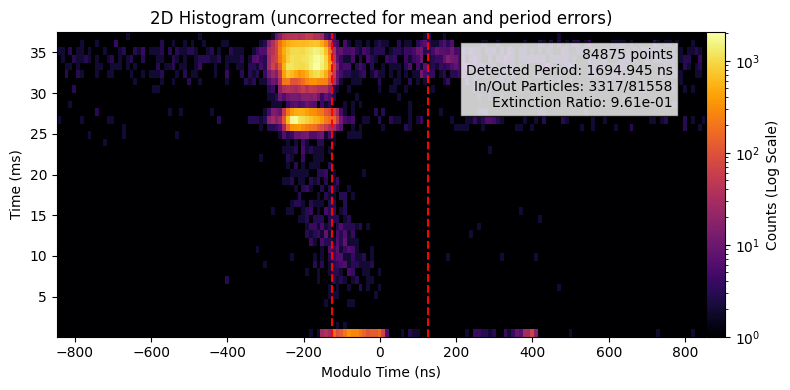

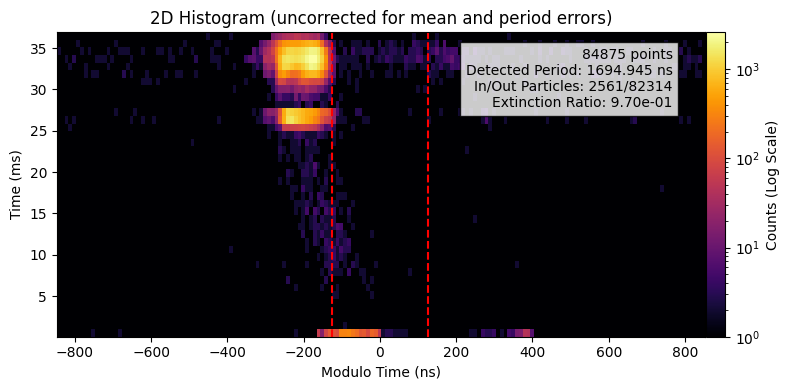

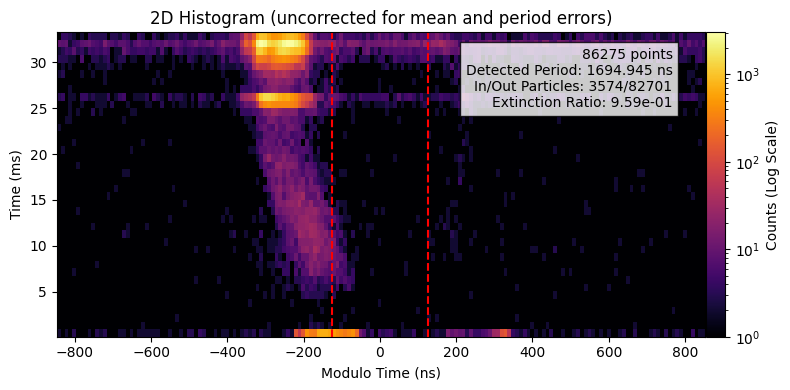

In [8]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################
from extinction_plots import plot_2d_histogram_delta_train

for channel, delta_train in enumerate(delta_trains):
    plot_2d_histogram_delta_train(delta_train, period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hex_check.folder_name}/2d_histogram_uncorrected.png",
                                  # bin_width_ns = 8,
                                  n_slices=40,
                                  figsize=(8, 4), colors = ['inferno'],
                                  title="2D Histogram (uncorrected for mean and period errors)")


[CH1] Normalized delta train mean: -185.408 ns, 
[CH2] Normalized delta train mean: -197.579 ns, 
[CH3] Normalized delta train mean: -236.026 ns, 


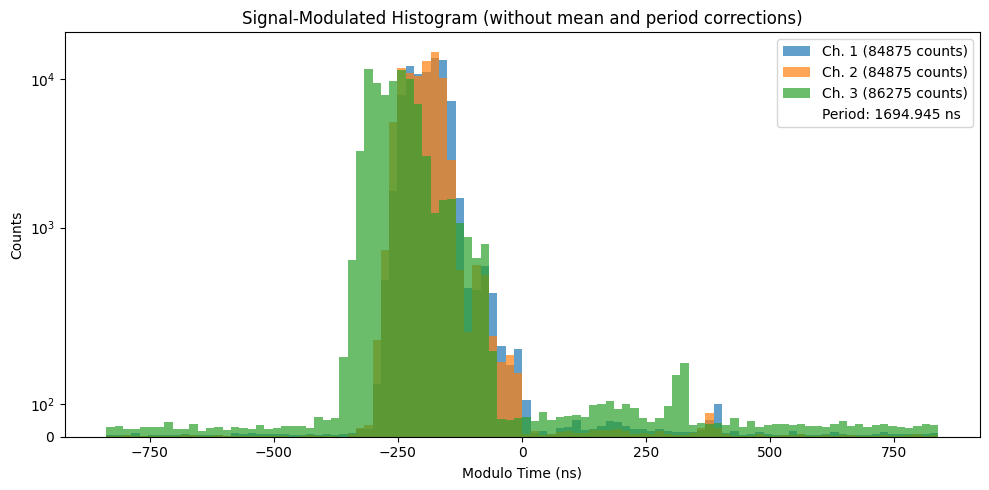

Delta train mean value: -206.50 ns
Starting mean: -181.24 ns, Ending mean: -250.31 ns, Error: -0.0035 ns, Old Period: 1694.9448 ns, New Period: 1694.9413 ns
Correcting phase of delta train by 79 ns, new mean: -0.42 ns
Correcting phase of (center of) delta train by 29 ns, new mean: 0.20 ns
Starting mean: -129.59 ns, Ending mean: -162.01 ns, Error: -0.0017 ns, Old Period: 1694.9413 ns, New Period: 1694.9397 ns
Correcting phase of (center of) delta train by 0 ns, new mean: 0.15 ns
Total correction on the mean: 108 ns
Correcting phase of (center of) delta train by -14 ns, new mean: -0.01 ns
Correcting phase of (center of) delta train by -3 ns, new mean: -0.01 ns
Correcting phase of (center of) delta train by 60 ns, new mean: -0.45 ns
New means for each of the three trains: 31.39 ms, 31.12 ms, 27.30 ms


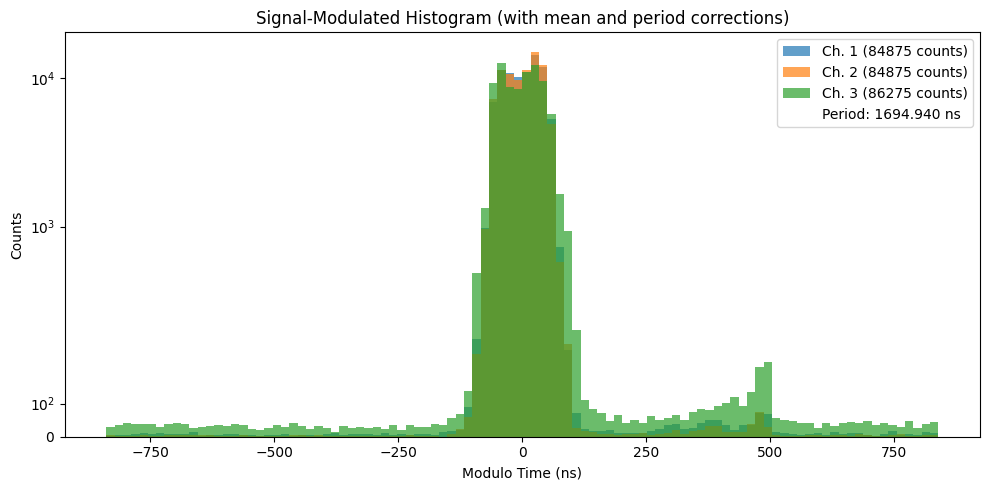

In [9]:
# #######################################################
# Pulse Centering
# #######################################################
# period = 1694.943 ... 0284359757
# new_period = 1694.933 0284359758
# new_period = period - 0.01

# normalize delta train by detected period once, but we will slightly nudge it to make it better now
normalized_delta_trains = []
for i, delta_train in enumerate(delta_trains):
    s = symmetric_mod(delta_train, period)
    print(f"[CH{i+1}] Normalized delta train mean: {s.mean():.3f} ns, ")
    normalized_delta_trains.append(s)
new_detected_period = period

# Plot histogram normalized by FFT period
plot_normalized_histogram(delta_trains, normalized_delta_trains, period, figsize=(10, 5),
                          file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_normalized_histogram.svg",
                          title=f"Signal-Modulated Histogram (without mean and period corrections)", log=True)

new_delta_trains, new_period = center_pulses(delta_trains, period)
normalized_delta_trains = [symmetric_mod(delta_train, new_period) for delta_train in new_delta_trains]

common_title_text = re.sub(r' - Channel \d', '', common_title_text)  # remove channel number from title

# Plot histogram normalized by FFT period
plot_normalized_histogram(new_delta_trains, normalized_delta_trains, new_period,
                          file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_normalized_histogram.svg",
                          figsize=(10, 5), log=True,
                          title = "Signal-Modulated Histogram (with mean and period corrections)")

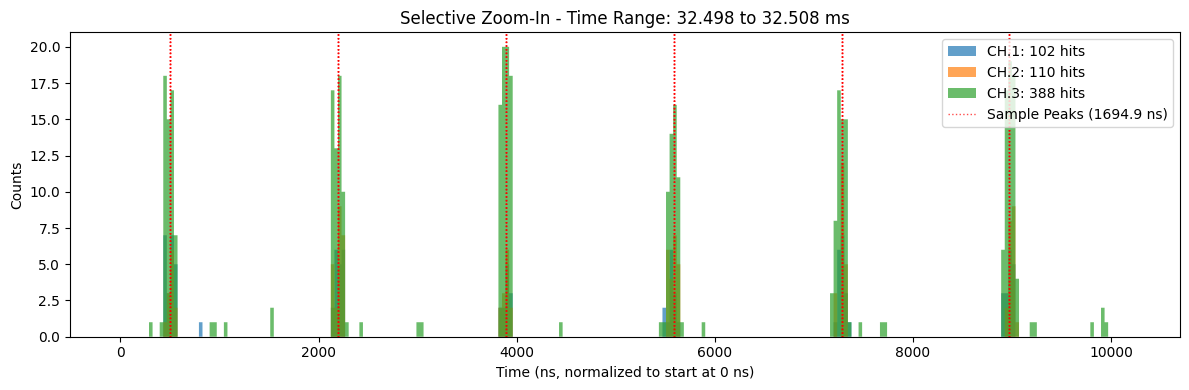

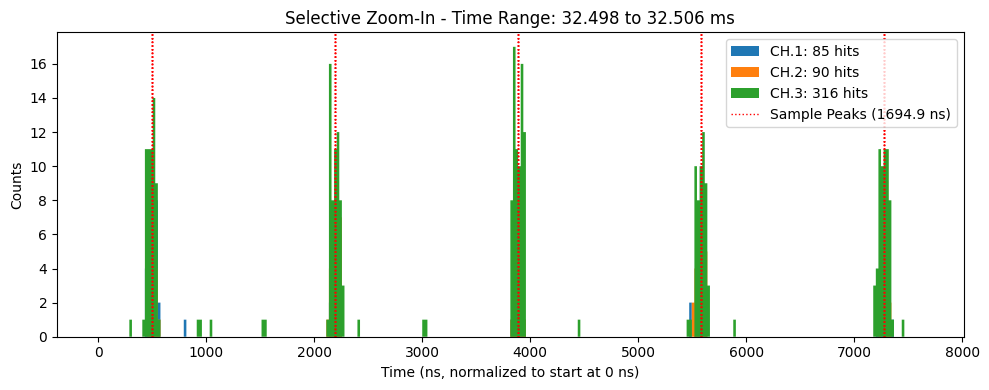

In [10]:
# Check this plot again after period and mean corrections
start = 32.5e6 - 32.5e6 % new_period - 500
end = start + new_period * 6
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=0.7, bin_size_ns=36,
                  fig_size = (12, 4), sample_offset = 500, legend=True,
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms",
                  file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_zoomed_corrected_1d_histogram.svg",
                  units="ns")

end = start + new_period * 4.5
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True, sample_offset=500,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=1, bin_size_ns=24,
                  fig_size=(10, 4), legend=True,
                  # file_name=f"img/{hex_check.folder_name}/zoomed_histogram.png",
                  file_name=f"img/{hex_check.folder_name}/MOP037_f4.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms")

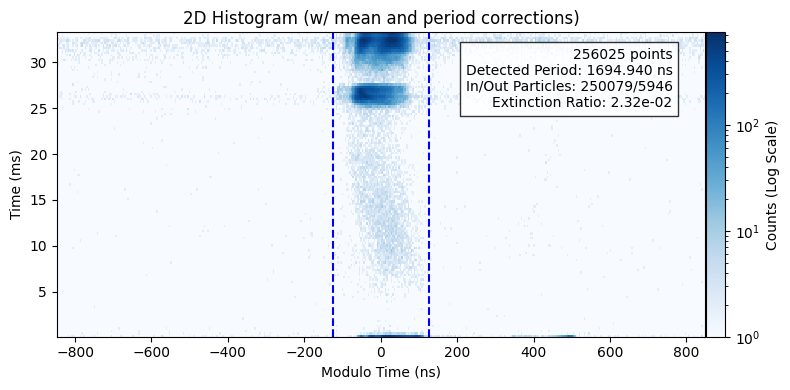

In [25]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#
# plot_2d_histogram_delta_train(delta_trains[2], period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 1,
#                               colors=['Reds'], bin_width_ns = 4,
#                               n_slices=125, alpha=1,
#                               title = f"2D Histogram, before/after corrections",
#                               )
#
# plot_2d_histogram_delta_train(new_delta_trains[2], new_period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 2,
#                               colors=['Greens'], bin_width_ns = 4,
#                               n_slices=125, alpha=0.5,
#                               )
#
# plt.tight_layout()
# plt.savefig(f"img/{hex_check.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.savefig(f"img/{hex_check.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.show()




# for channel, new_delta_train in enumerate(new_delta_trains):
#     plot_2d_histogram_delta_train(new_delta_train, new_period, common_title_text=common_title_text,
#                                   channel = channel + 1,
#                                   # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
#                                   file_name=f"img/{hex_check.folder_name}/2d_histogram_corrected.png",
#                                   colors=['inferno'],
#                                   n_slices=40,
#                                   figsize=(8, 4),
#                                   title="2D Histogram (w/ mean and period corrections)",
#                                   )

all_trains = []
all_trains = np.concatenate(new_delta_trains)  # combine all delta trains into one
plot_2d_histogram_delta_train(all_trains, new_period, common_title_text=common_title_text,
                                  channel = 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hex_check.folder_name}/2d_histogram_corrected.png",
                                  colors=['Blues'],
                                  n_slices=125, bin_width_ns=4,
                                  figsize=(8, 4),
                                  title="2D Histogram (w/ mean and period corrections)",
                                  )


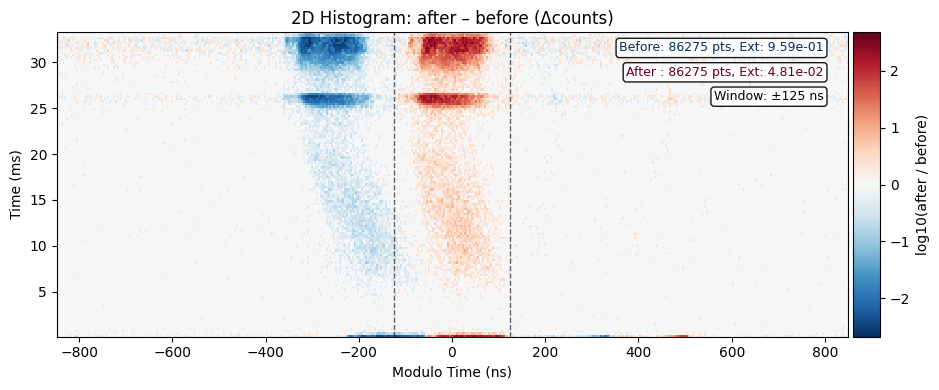

In [12]:
from socketudp.extinction_plots import plot_2d_histogram_delta_train_compare

fig, ax = plt.subplots(1, 1, figsize=(9.5, 4))
plot_2d_histogram_delta_train_compare(
    before_delta=delta_trains[2],
    after_delta=new_delta_trains[2],
    before_period_ns=period,
    after_period_ns=new_period,      # or period; both are fine as long as one is used for binning
    common_title_text=common_title_text,
    fig_ax=(fig, ax),
    bin_width_ns=4,
    n_slices=125,
    mode="ratio",                         # "diff" or "ratio"
    title="2D Histogram: after – before (Δcounts)",
)
plt.tight_layout()
plt.savefig(f"img/{hex_check.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig(f"img/{hex_check.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()




In [13]:
# #######################################################
# EXTINCTION MEASUREMENT
# #######################################################

for i, normalized_delta_train in enumerate(normalized_delta_trains):
    # define +/- 125 ns window as "in-time", and everything else as "out-of-time"
    in_time_counts = np.sum(np.abs(normalized_delta_train) <= 125)
    out_of_time_counts = len(normalized_delta_train) - in_time_counts
    print(f"[CH{i+1}] In-time counts: {in_time_counts}, Out-of-time counts: {out_of_time_counts}")
    extinction_ratio = out_of_time_counts / (in_time_counts + out_of_time_counts)
    print(f"[CH{i+1}] Extinction ratio: {extinction_ratio:.3e} (out-of-time / total counts)")


[CH1] In-time counts: 83696, Out-of-time counts: 1179
[CH1] Extinction ratio: 1.389e-02 (out-of-time / total counts)
[CH2] In-time counts: 84256, Out-of-time counts: 619
[CH2] Extinction ratio: 7.293e-03 (out-of-time / total counts)
[CH3] In-time counts: 82127, Out-of-time counts: 4148
[CH3] Extinction ratio: 4.808e-02 (out-of-time / total counts)


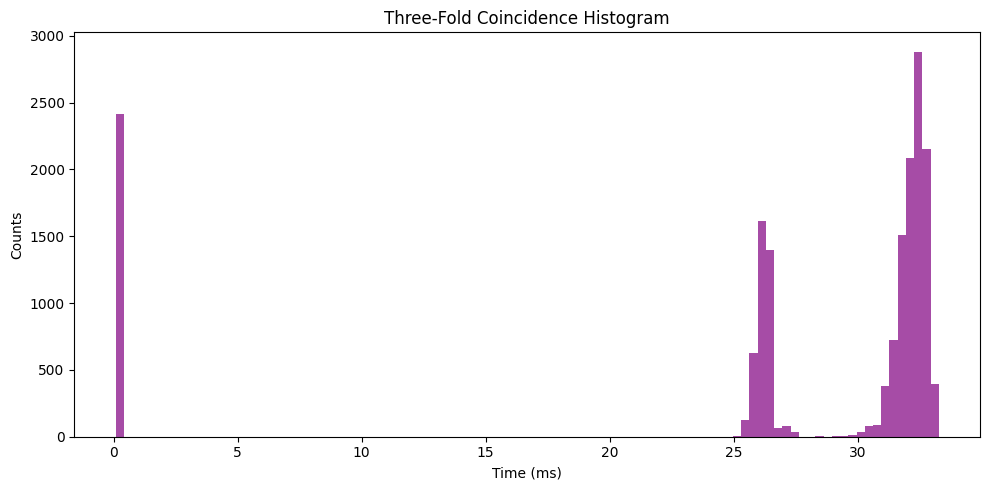

2415 points
Detected Period: 1694.940 ns
In/Out Particles: 2275/140
Extinction Ratio: 5.80e-02
14297 points
Detected Period: 1694.940 ns
In/Out Particles: 14182/115
Extinction Ratio: 8.04e-03


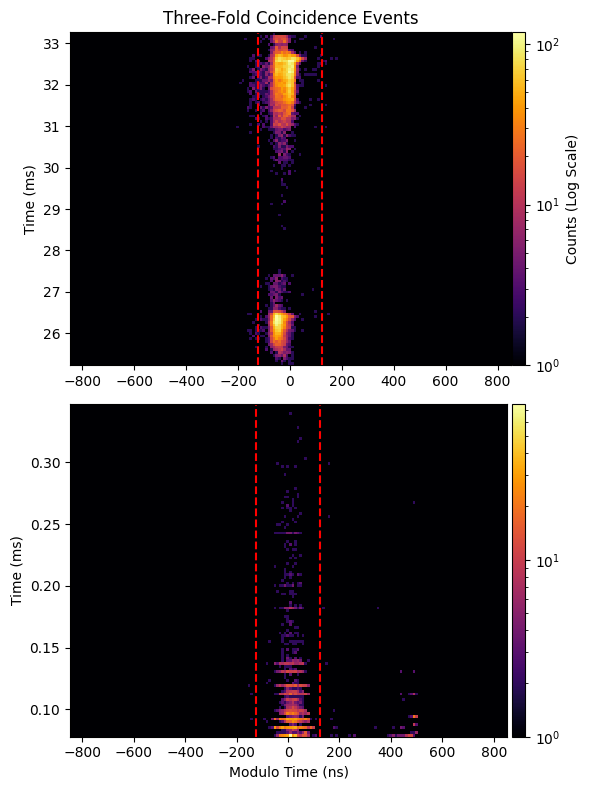

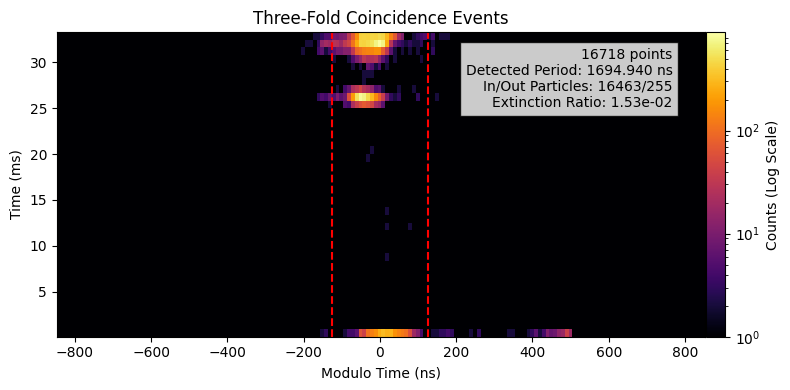

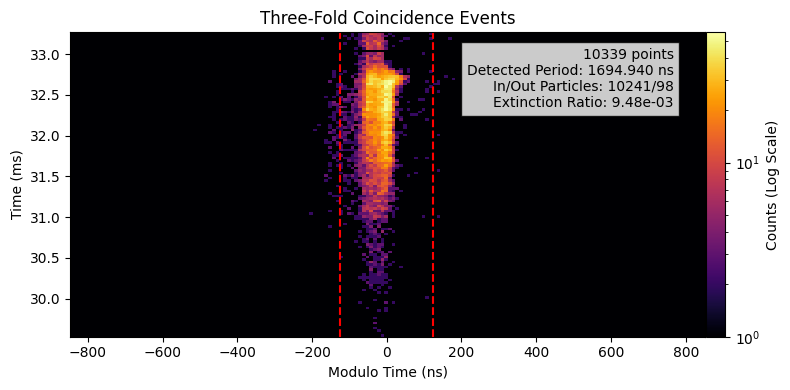

In [30]:
# ############################
# THREE FOLD COINCIDENCE
# ############################

average_points = get_three_fold_coincidence_points(new_delta_trains)

# average points is now a simple list of timestamps, plot on a histogram
if average_points.size > 0:
    three_fold_title = re.sub(r"\nTime Range: .*? ms", "", common_title_text)
    plt.figure(figsize=(10, 5))
    plt.hist(average_points / 1e6, bins=100, color='purple', alpha=0.7)
    plt.xlabel("Time (ms)")
    plt.ylabel("Counts")
    plt.title("Three-Fold Coincidence Histogram")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    # plot 2d histogram of this as well
    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[1]), subplot_no = 2,
                                  common_title_text="Three-Fold Coincidence Events)",
                                  colors=['inferno'],
                                  file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=False, t_range=(0, 2e6))

    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[0]), subplot_no = 1,
                              common_title_text="Three-Fold Coincidence Events",
                              colors=['inferno'], file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                              figsize=(6, 8), textbox=False, t_range=(25e6, np.inf))

    file_name = f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram_combined.svg"
    if file_name:
        plt.savefig(file_name, dpi=300)
    plt.show()

    # plot 2d histogram of this as well
    plot_2d_histogram_delta_train(average_points, new_period,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'],
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram.svg",
                                  n_slices=40,
                                  figsize=(8, 4), textbox=True, t_range=(0, 40e6))

    plot_2d_histogram_delta_train(average_points, new_period,
                              common_title_text="Three-Fold Coincidence Events",
                              colors=['inferno'], n_slices=120,
                              figsize=(8, 4), textbox=True, t_range=(29.5e6, np.inf))